In [4]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -q fastkaggle

from fastkaggle import *

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.6.3 requires fastcore<1.5,>=1.3.27, but you have fastcore 1.5.55 which is incompatible.


This is part 2 of the [Road to the Top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) series, in which I show the process I used to tackle the [Paddy Doctor](https://www.kaggle.com/competitions/paddy-disease-classification) competition, leading to four 1st place submissions. If you haven't already, first check out [part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1).

## Going faster

First we'll repeat the steps we used last time to access the data and ensure all the latest libraries are installed:

In [5]:
!pip install -Uqq timm==0.6.13

In [6]:
comp = 'paddy-disease-classification'
path = setup_comp(comp)

In [7]:
path.ls()

(#4) [Path('../input/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-disease-classification/train_images'),Path('../input/paddy-disease-classification/train.csv'),Path('../input/paddy-disease-classification/test_images')]

In [8]:
from fastai.vision.all import *
set_seed(42)

In [9]:
trn_path = Path('../input/paddy-disease-classification/train_images')

# Criando uma referência (Path) para a pasta sml, para carregar dados de treino pequenos (úteis para experimentação antes de rodar o dataset completo).

In [10]:
trn_path.ls()

(#10) [Path('../input/paddy-disease-classification/train_images/tungro'),Path('../input/paddy-disease-classification/train_images/hispa'),Path('../input/paddy-disease-classification/train_images/downy_mildew'),Path('../input/paddy-disease-classification/train_images/bacterial_leaf_streak'),Path('../input/paddy-disease-classification/train_images/bacterial_leaf_blight'),Path('../input/paddy-disease-classification/train_images/brown_spot'),Path('../input/paddy-disease-classification/train_images/blast'),Path('../input/paddy-disease-classification/train_images/normal'),Path('../input/paddy-disease-classification/train_images/dead_heart'),Path('../input/paddy-disease-classification/train_images/bacterial_panicle_blight')]

This will give us 192x256px images. Let's take a look:

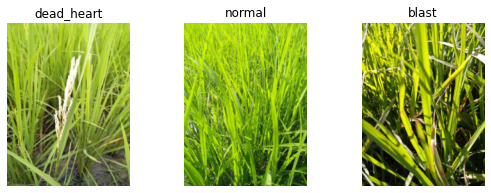

In [11]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize((256,192)))

dls.show_batch(max_n=3)

In this notebook, we'll be experimenting with a few different architectures and image processing approaches (item and batch transforms). In order to make this easier, we'll put our modeling steps together into a little function which we can pass the architecture, item transforms, and batch transforms to:

In [12]:
def train(arch, item, batch, epochs=5):
    import builtins, timm
    builtins.timm = timm
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

# arch: a arquitetura do modelo (ex: resnet18, resnet34, etc.).
# item: transformações aplicadas a cada item (imagem) antes de entrar no batch — ex: redimensionamento. Para preparar as imagens para o modelo (tamanho, corte).
# batch: transformações aplicadas no batch inteiro, ex: data augmentation.
# epochs=5: número de épocas de treino (padrão: 5).

In [15]:
learn = train('resnet26d', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.878984,1.514555,0.485824,00:47


epoch,train_loss,valid_loss,error_rate,time
0,1.226557,1.023756,0.335416,00:49
1,0.976297,0.735915,0.241711,00:47
2,0.710464,0.557234,0.187410,00:47
3,0.527390,0.412860,0.137914,00:47
4,0.438523,0.400188,0.128784,00:48


## A ConvNeXt model

In [13]:
arch = 'convnext_small_in22k'

In [17]:
learn = train(arch, item=Resize(192, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.346776,0.823741,0.264296,00:58


epoch,train_loss,valid_loss,error_rate,time
0,0.666078,0.485639,0.163383,00:59
1,0.526047,0.422638,0.137434,01:01
2,0.327412,0.256399,0.078808,01:01
3,0.214820,0.148092,0.043248,01:01
4,0.133707,0.133724,0.041807,01:03


Wow our error rate has halved! That's a great result. And, as expected, the speed hasn't gone up much at all. This seems like a great model for iterating on.

## Preprocessing experiments

So, what shall we try first? One thing which can make a difference is whether we "squish" a rectangular image into a square shape by changing it's aspect ratio, or randomly crop out a square from it, or whether we add black padding to the edges to make it a square. In the previous version we "squished". Let's try "crop" instead, which is fastai's default:

In [14]:
learn = train(arch, item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.357003,0.866754,0.284959,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.730185,0.571874,0.189332,00:55
1,0.570893,0.354493,0.115329,00:55
2,0.390914,0.244269,0.076406,00:55
3,0.253203,0.152682,0.047093,00:56
4,0.178880,0.150522,0.049015,00:56


That doesn't seem to have made much difference...

We can also try padding, which keeps all the original image without transforming it -- here's what that looks like:

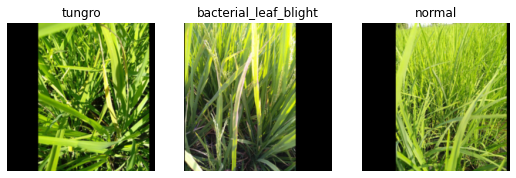

In [15]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [16]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

# Importante 
# batch=aug_transforms(size=(171,128), min_scale=0.75): Aplica augmentations por batch (como flip, rotate, zoom, etc.) E depois faz um crop final aleatório para tamanho (171x128). O min_scale=0.75 controla o quanto o modelo pode aplicar zoom-in (ou corte).
# Isso faz crop que elimina pedaços da imagem (destrutivo), o que pode ser ruim se existem detalhes importantes em determinada parte.
# batch=aug_transforms(size=(171,128), min_scale=1.0, max_zoom=1.0) > isso faz data augmentation sem crop

epoch,train_loss,valid_loss,error_rate,time
0,1.278736,0.912675,0.287362,01:09


epoch,train_loss,valid_loss,error_rate,time
0,0.692499,0.459251,0.154253,01:14
1,0.548397,0.328609,0.108121,01:13
2,0.350425,0.238406,0.071600,01:13
3,0.205914,0.161598,0.046132,01:12
4,0.149513,0.148963,0.044210,01:12


## Test time augmentation

To make the predictions even better, we can try [test time augmentation](https://nbviewer.org/github/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb#Test-Time-Augmentation) (TTA), which [our book](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527) defines as:

> *During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.*

Before trying that out, we'll first see how to check the predictions and error rate of our model without TTA:

In [17]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

# learn.dls.valid
# Acessa o DataLoader de validação
# Equivalente a learn.dls[1]
# Contém o conjunto de dados usado para calcular valid_loss e metrics

# learn.get_preds(dl=valid)
# Executa o modelo em todo o conjunto de validação, sem aplicar batch_tfms como augmentations
# Retorna dois tensores:
# preds: predições do modelo (probabilidades por classe se for classificação)
# targs: rótulos verdadeiros

In [19]:
error_rate(preds, targs)

TensorBase(0.0442)

That's the same error rate we saw at the end of training, above, so we know that we're doing that correctly.

Here's what our data augmentation is doing -- if you look carefully, you can see that each image is a bit lighter or darker, sometimes flipped, zoomed, rotated, warped, and/or zoomed:

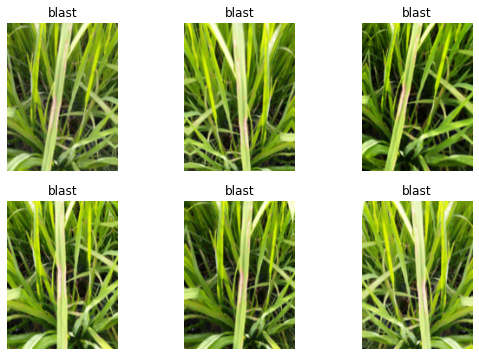

In [20]:
learn.dls.train.show_batch(max_n=6, unique=True)

If we call `tta()` then we'll get the average of predictions made for multiple different augmented versions of each image, along with the unaugmented original:

In [22]:
tta_preds,_ = learn.tta(dl=valid)

Let's check the error rate of this:

In [23]:
error_rate(tta_preds, targs)

TensorBase(0.0365)

That's a huge improvement! We'll definitely want to use this for any submission we make!

## Scaling up

Now that we've got a pretty good model and preprocessing approach, let's scale it up to larger images and more epochs. We'll switch back our path to the original un-resized images, and use 12 epochs using our best settings so far, with larger final augmented images:

In [ ]:
trn_path = path/'train_images'

In [24]:
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.244382,0.847186,0.252283,01:39


epoch,train_loss,valid_loss,error_rate,time
0,0.595894,0.316119,0.102835,02:08
1,0.445364,0.371886,0.120615,02:08
2,0.388143,0.342277,0.106679,02:07
3,0.345400,0.259140,0.085536,02:08
4,0.252058,0.221069,0.066795,02:07
5,0.202919,0.176600,0.046612,02:07
6,0.149448,0.135565,0.038924,02:07
7,0.103675,0.106535,0.027391,02:07
8,0.084114,0.113984,0.026430,02:07
9,0.059176,0.103913,0.025949,02:07


This is around twice as accurate as our previous best model - let's see how it performs with TTA too:

In [25]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0202)

Once again, we get a big boost from TTA. This is one of the most under-appreciated deep learning tricks, in my opinion! (I'm not sure there's any other frameworks that make it quite so easy, so perhaps that's part of the reason why...)

## Submission

We're now ready to get our Kaggle submission sorted. First, we'll grab the test set like we did in the last notebook:

In [ ]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)

Next, do TTA on that test set:

In [ ]:
preds,_ = learn.tta(dl=tst_dl)

We need to indices of the largest probability prediction in each row, since that's the index of the predicted disease. `argmax` in PyTorch gives us exactly that:

In [ ]:
idxs = preds.argmax(dim=1)

Now we need to look up those indices in the `vocab`. Last time we did that using pandas, although since then I realised there's an even easier way!:

In [ ]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [ ]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'convnext small 256x192 12 epochs tta', comp)

This gets a score of 0.9827, which is well within the top 25% of the competition -- that's a big improvement, and we're still using a single small model!

In [ ]:
# This is what I use to push my notebook from my home PC to Kaggle

if not iskaggle:
    push_notebook('jhoward', 'small-models-road-to-the-top-part-2',
                  title='Small models: Road to the Top, Part 2',
                  file='small-models-road-to-the-top-part-2.ipynb',
                  competition=comp, private=True, gpu=True)

## Conclusion

We've made a big step today, despite just using a single model that trains in under 20 minutes even on Kaggle's rather under-powered machines. Next time, we'll try scaling up to some bigger models and doing some ensembling.

If you found this notebook useful, please remember to click the little up-arrow at the top to upvote it, since I like to know when people have found my work useful, and it helps others find it too. And if you have any questions or comments, please pop them below -- I read every comment I receive!